# Model Version 1 (3 layer sequential)

Import required packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

Set our data directory and verify image_count

In [ ]:
data_dir = pathlib.Path('small sample (2-3 imgs per class)')

image_count = (len(list(data_dir.glob('*/*.png'))) + 
               len(list(data_dir.glob('*/*.jpg'))) + 
               len(list(data_dir.glob('*/*.jpeg'))))
print(image_count)

22


Define parameters, convert our directory of images into a tensorflow dataset

In [ ]:
batch_size = 1 # accounting for 1/very few images per class
img_height = 180
img_width = 180

ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 22 files belonging to 8 classes.


Set up variables for building our training and validation subsets

In [ ]:
class_names = ds.class_names
num_classes = len(class_names)
validation_split = .2

# initializing val_ds and train_ds as "empty" arrays (set to ds to preserve dimensions, filtered all content out)
val_ds = ds.filter(lambda x, l: tf.math.equal(l[0], num_classes + 1))
train_ds = ds.filter(lambda x, l: tf.math.equal(l[0], num_classes + 1))

We want validation representation from each class. however, its very small dataset so we can't rely on random validation sampling to assign validation images evenly from each class, so we gaurantee that there is at least one validation image for each class here

In [ ]:
for i in range(num_classes):
    filtered_ds = ds.filter(lambda x, l: tf.math.equal(l[0], i))
  
    fds_list = list(filtered_ds)
    val_count = len(fds_list) // (1/validation_split)

    # gaurantee that there is at least one validation image for each class
    if val_count == 0:
      val_count = 1

    if len(fds_list) > 0:
      val_ds = val_ds.concatenate(filtered_ds.take(val_count))
      train_ds = train_ds.concatenate(filtered_ds.skip(val_count))

I'm pretty sure this stuff only matters for much larger datasets but still good practice to include. Note: we shuffle training data but not validation data

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Define and build model (note data_augmentation step)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
  ]
)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Run model (seems to level out around 60 epochs)

In [ ]:
epochs=60

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Generate accuracy and loss plots

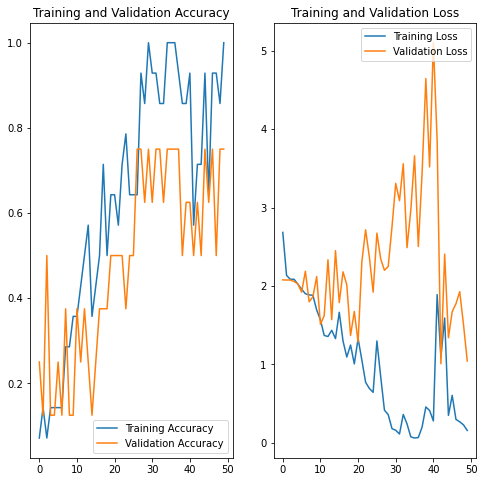

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Show accuracy of augmented training images

This image most likely belongs to banana with a 99.79 percent confidence.
This image most likely belongs to banana with a 99.92 percent confidence.
This image most likely belongs to banana with a 99.24 percent confidence.
This image most likely belongs to banana with a 97.10 percent confidence.
This image most likely belongs to banana with a 99.95 percent confidence.
This image most likely belongs to banana with a 99.91 percent confidence.
This image most likely belongs to banana with a 99.75 percent confidence.
This image most likely belongs to banana with a 99.91 percent confidence.
This image most likely belongs to banana with a 99.92 percent confidence.


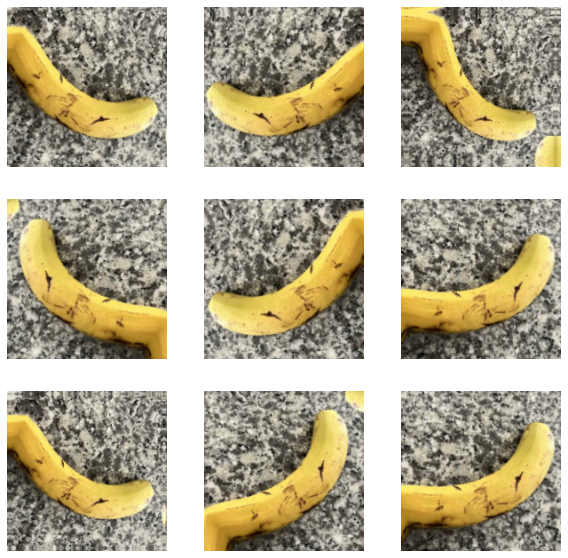

In [ ]:
from tensorflow.python.eager.monitoring import CounterCell

plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
    for i in range(9):
      augmented_images = data_augmentation(images)
      img = augmented_images[0].numpy().astype("uint8")

      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(img)
      plt.axis("off")
      i += 1

      img_array = tf.keras.utils.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0)

      predictions = model.predict(img_array)
      score = tf.nn.softmax(predictions[0])

      print(
          "This image most likely belongs to {} with a {:.2f} percent confidence."
          .format(class_names[np.argmax(score)], 100 * np.max(score))
      )

Show the results for the validation images

This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to avocado toast with a 95.54 percent confidence.
This image most likely belongs to banana with a 98.74 percent confidence.
This image most likely belongs to cereal with a 92.71 percent confidence.
This image most likely belongs to avocado toast with a 54.99 percent confidence.
This image most likely belongs to meatball sub with a 74.09 percent confidence.
This image most likely belongs to oats with a 85.62 percent confidence.
This image most likely belongs to apple with a 90.04 percent confidence.


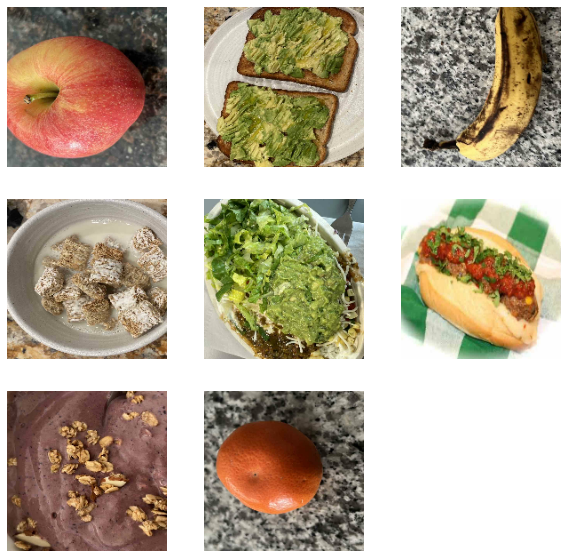

In [ ]:
plt.figure(figsize=(10, 10))
imgIndex = 0

for images, _ in val_ds.take(8):
    img = images[0].numpy().astype("uint8")

    ax = plt.subplot(3, 3, imgIndex + 1)
    plt.imshow(img)
    plt.axis("off")
    imgIndex += 1

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

Test on new images that the model did not train or validate with

This image most likely belongs to cereal with a 88.24 percent confidence.
This image most likely belongs to banana with a 96.50 percent confidence.
This image most likely belongs to cereal with a 50.49 percent confidence.


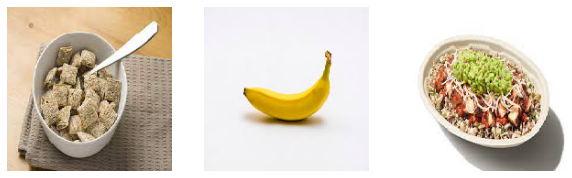

In [ ]:
from tensorflow.python.eager.monitoring import CounterCell

plt.figure(figsize=(10, 10))
test_images = ['test images/shredded wheat.jpeg',
               'test images/banana.jpeg',
               'test images/chipotle1.jpeg']
imgIndex = 0

for image in test_images:
  test_img_path = pathlib.Path(image)

  img = tf.keras.utils.load_img(
      test_img_path, target_size=(img_height, img_width)
  )

  # show test images
  ax = plt.subplot(1, 3, imgIndex + 1)
  plt.imshow(img)
  plt.axis("off")
  imgIndex += 1

  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )